In [1]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv 
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
with gzip.open('NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))

In [3]:
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

In [4]:
conn=np.load('NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

In [5]:
def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

In [6]:
congestion_data = np.load('NCSU-DigIC-GraphData-2023-07-25/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])

In [7]:
def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst

In [8]:
for k in range(instances.shape[0]):
    #print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
        
instances['routing_demand'] = demand

In [9]:
instances.head()

,name,id,xloc,yloc,cell,orient,routing_demand
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0


In [10]:
np.random.seed(42)

In [11]:
torch.manual_seed(42)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.

In [88]:
# my model training got worse when I utilized GPU instead of CPU? 

a)

In [73]:
def graph_data_split(instances, A, create_test_data=True):
    '''
    Preprocesses graph data.
    
    Parameters:
    - instances: Pandas DataFrame, node instances of design
    - A: Sparse matrix, adjacency matrix of graph edge connections
    '''
    # get X, y, edge indices
    X = torch.tensor(instances[['xloc', 'yloc', 'cell', 'orient']].values)
    y = torch.tensor(instances['routing_demand'].values)
    edge_index = from_scipy_sparse_matrix(A)[0]
    
    # use Data object
    data = Data(x=X, edge_index=edge_index, y=y)
    # use .7 train .3 test split
    random_split = RandomNodeSplit(num_val=0.0, num_test=0.3)
    # splits Data object
    data_split = random_split(data)
    
    # split into train test
    X_train = data_split.x[data_split.train_mask].float()
    y_train = data_split.y[data_split.train_mask].float()
    X_test = data_split.x[data_split.test_mask].float()
    y_test = data_split.y[data_split.test_mask].float()
    
    # indices in train nodes
    train_indices = set(torch.argwhere(data_split.train_mask).squeeze().tolist())
    # reset edge indices
    train_map = {old: new for old, new in zip(train_indices, range(len(train_indices)))}
    train_edges = torch.tensor([(train_map[src.item()], train_map[dst.item()]) for src, dst in zip(data_split.edge_index[0], data_split.edge_index[1]) if src.item() in train_indices and dst.item() in train_indices]).T
    # indices in test nodes
    test_indices = set(torch.argwhere(data_split.test_mask).squeeze().tolist())
    # reset edge indices
    test_map = {old: new for old, new in zip(test_indices, range(len(test_indices)))}
    test_edges = torch.tensor([(test_map[src.item()], test_map[dst.item()]) for src, dst in zip(data_split.edge_index[0], data_split.edge_index[1]) if src.item() in test_indices and dst.item() in test_indices]).T
    
    # create train test Data objects
    train_data = Data(x=X_train, y=y_train, edge_index=train_edges)
    test_data = Data(x=X_test, y=y_test, edge_index=test_edges)
    
    return train_data, test_data

In [74]:
split_data = graph_data_split(instances=instances, A=A)
train_data = split_data[0]
test_data = split_data[1]

In [75]:
class GCN(nn.Module):
    def __init__(self, hidden_dim, hidden_layers):
        super().__init__()
        self.conv1 = GCNConv(4, hidden_dim)
        self.hidden = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(hidden_layers)])
        self.linear = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, edge_index):
        
        x = F.relu(self.conv1(x, edge_index))
        for layer in self.hidden:
            x = F.relu(layer(x, edge_index))
        x = self.linear(x)
        
        return x

In [76]:
def train(model, data):
    
    num_epochs = 2000
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
            
            optimizer.zero_grad()
            inputs = data.x.to(device)
            labels = data.y.to(device)
            edge_index = data.edge_index.to(device)
            output = model(inputs, edge_index)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
#             if epoch % 10 == 0:
#                 print(f'Epoch {epoch}, Loss: {loss:.2f}')
#     print('Finished Training')
    return loss

In [83]:
ks = list(range(0, 5)) # 0 to 4 hidden layers
hidden_layer_dim = 512
train_losses = []
test_losses = []
for k in ks:
    model = GCN(hidden_layer_dim, k)
    loss = train(model, train_data)
    train_losses.append(loss.item())
    test_loss = ((model(test_data.x.to(device), test_data.edge_index.to(device)) - test_data.y.to(device))**2).mean()
    test_losses.append(test_loss.item())

100%|██████████| 2000/2000 [01:04<00:00, 30.87it/s]


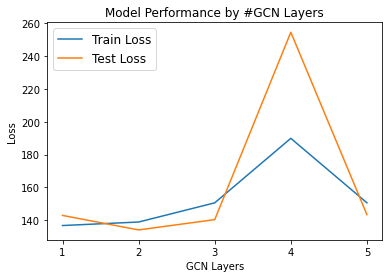

In [84]:
plt.figure(figsize=(6,4))
train_plot = plt.plot(ks, train_losses, label='Train Loss')
test_plot = plt.plot(ks, test_losses, label='Test Loss')
plt.xticks(ks, np.array(ks) + 1)
plt.xlabel('GCN Layers')
plt.ylabel('Loss')
plt.title('Model Performance by #GCN Layers')
plt.legend(prop={'size': 12})
plt.show()

In [85]:
class GCN_attention(nn.Module):
    def __init__(self, hidden_dim, hidden_layers):
        super().__init__()
        self.conv1 = GCNConv(4, hidden_dim)
        self.hidden = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(hidden_layers)])
        self.linear = nn.Linear(hidden_dim, 1)
        
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        # concat then linear
        attention_weights = torch.cat((x, x), dim=1)
        attention_weights = self.attention(attention_weights)
        attention_weights = self.softmax(attention_weights)
        x = x * attention_weights
    
        for layer in self.hidden:
            x = layer(x, edge_index)
            x = F.relu(x)
        
        x = self.linear(x)
        
        return x

In [86]:
hidden_layer_dim = 512
train_losses = []
test_losses = []
for k in ks:
    # create model
    model_attention = GCN_attention(hidden_dim=hidden_layer_dim, hidden_layers=k)
    # train model
    loss = train(model_attention, train_data)
    train_losses.append(loss.item())
    test_loss = ((model_attention(test_data.x.to(device), test_data.edge_index.to(device)) - test_data.y.to(device))**2).mean()
    test_losses.append(test_loss.item())

100%|██████████| 2000/2000 [01:06<00:00, 30.30it/s]


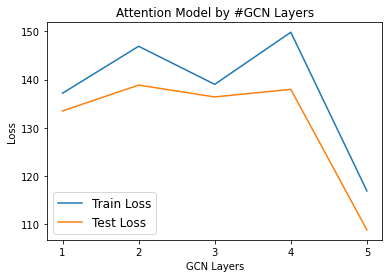

In [87]:
plt.figure(figsize=(6,4))
train_plot = plt.plot(ks, train_losses, label='Train Loss')
test_plot = plt.plot(ks, test_losses, label='Test Loss')
plt.xticks(ks, np.array(ks) + 1)
plt.xlabel('GCN Layers')
plt.ylabel('Loss')
plt.title('Attention Model by #GCN Layers')
plt.legend(prop={'size': 12})
plt.show()

# 2.

a.

In [22]:
# train with 1 to 12
leave_ins = range(1, 13)
# test with 13
leave_out = 13

Initialize train data of xbar/1 to xbar/12

In [23]:
train_instances = []
adjacency_matrices = []

for i in leave_ins:
    print(i)
    with gzip.open(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar.json.gz', 'rb') as f:
        design = json.loads(f.read().decode('utf-8'))
        
    instances = pd.DataFrame(design['instances'])
    nets = pd.DataFrame(design['nets'])
    
    conn=np.load(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar_connectivity.npz')
    A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
    A = A.__mul__(A.T)
    adjacency_matrices.append(A)
    
    congestion_data = np.load(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{i}/xbar_congestion.npz')
    xbst = buildBST(congestion_data['xBoundaryList'])
    ybst = buildBST(congestion_data['yBoundaryList'])
    demand = np.zeros(shape=[instances.shape[0], ])
    
    for k in range(instances.shape[0]):
        xloc = instances.iloc[k]['xloc']
        yloc = instances.iloc[k]['yloc']
        i, j = getGRCIndex(xloc, yloc, xbst, ybst)
        d = 0
        for l in list(congestion_data['layerList']):
            lyr = list(congestion_data['layerList']).index(l)
            d += congestion_data['demand'][lyr][i][j]
        demand[k] = d
        
    instances['routing_demand'] = demand
    train_instances.append(np.array(instances))

1
2
3
4
5
6
7
8
9
10
11
12


In [53]:
train_data_list = []
for instance, A in zip(train_instances, adjacency_matrices):
    # get X, y, edge indices
    X = torch.tensor(instance[:,2:6].astype(float))
    y = torch.tensor(instance[:,-1].astype(float))
    edge_index = from_scipy_sparse_matrix(A)[0]

    # use Data object
    data = Data(x=X, edge_index=edge_index, y=y)
    train_data_list.append(train_data)

Initialize test data of xbar/13

In [55]:
with gzip.open(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{leave_out}/xbar.json.gz', 'rb') as f:
        design = json.loads(f.read().decode('utf-8'))
        
instances_test = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

conn=np.load(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{leave_out}/xbar_connectivity.npz')
A_test = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A_test = A_test.__mul__(A_test.T)

congestion_data = np.load(f'NCSU-DigIC-GraphData-2023-07-25/xbar/{leave_out}/xbar_congestion.npz')
xbst = buildBST(congestion_data['xBoundaryList'])
ybst = buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape=[instances_test.shape[0], ])

for k in range(instances_test.shape[0]):
    xloc = instances_test.iloc[k]['xloc']
    yloc = instances_test.iloc[k]['yloc']
    i, j = getGRCIndex(xloc, yloc, xbst, ybst)
    d = 0
    for l in list(congestion_data['layerList']):
        lyr = list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d

instances_test['routing_demand'] = demand

In [64]:
# get X, y, edge indices
X = torch.tensor(instances_test[['xloc', 'yloc', 'cell', 'orient']].values).float()
y = torch.tensor(instances_test['routing_demand'].values).float()
edge_index = from_scipy_sparse_matrix(A_test)[0]

# use Data object
data = Data(x=X, edge_index=edge_index, y=y)
# create train test Data objects
test_data = Data(x=X, y=y, edge_index=edge_index)

Trainer

In [59]:
def train_lists(model, data):
    
    # epochs divided by # xbar samples
    num_epochs = 2000 // 12
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    model.to(device)
    
    for epoch in tqdm(range(num_epochs)):
            
            optimizer.zero_grad()
            inputs = data.x.to(device)
            labels = data.y.to(device)
            edge_index = data.edge_index.to(device)
            output = model(inputs, edge_index)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
#             if epoch % 10 == 0:
#                 print(f'Epoch {epoch}, Loss: {loss:.2f}')
#     print('Finished Training')
    return loss

In [60]:
hidden_layer_dim = 512
model_attention = GCN_attention(hidden_layer_dim, 4)
for train_data in train_data_list:
    loss = train_lists(model_attention, train_data)

100%|██████████| 166/166 [00:05<00:00, 28.85it/s]


In [65]:
test_loss = ((model_attention(test_data.x.to(device), test_data.edge_index.to(device)) - test_data.y.to(device))**2).mean()

In [69]:
test_loss

tensor(117.0607, device='cuda:0', grad_fn=<MeanBackward0>)

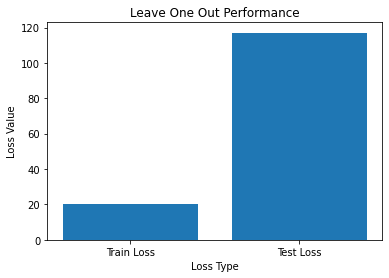

In [71]:
plt.figure(figsize=(6,4))
labels = ['Train Loss', 'Test Loss']
loss_values = [loss.item(), test_loss.item()]
plt.bar(labels, loss_values)
plt.xlabel('Loss Type')
plt.ylabel('Loss Value')
plt.title('Leave One Out Performance')
plt.show()